# DSCI 100 Group 10 Group Project Proposal

## Members
- Nishant Molleti - 21147343
- Ajitesh Taneja - 69832913
- Asteria Xu - 56376452
- Audrey Tsung - 60770633

## Introduction

Pulsars are rotating Neutron stars that emit radio waves at regular intervals, and their detection is important in fields such as astrophysics and radio astronomy. However, pulsars are challenging to detect due to interference and noise at radio frequencies, thus giving false signals. To improve detection, machine learning techniques have been employed. 

The question that we want to address is: How can we build a machine learning model that can be used to accurately classify pulsars from non-pulsars, or unwanted noise and interferences?

The dataset which we are using to answer this question is the HTRU2 dataset, which contains 17,898 observations of pulsars and non-pulsars, obtained from the High Time Resolution Universe Survey. Each observation has 8 features, including the mean, standard deviation, excess kurtosis and skewness of the integrated profile and DM-SNR curve. Additionally, a binary label called 'class' is used to indicate whether an observation is a pulsar or not. 


In [146]:
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)

# Preliminary Exploratory Data Analysis

Now, we will read the dataset from the web into R, and then clean our data.

In [147]:
# Adding the column names to the dataset because they originally did not exist
columns <- c("mean_ip", "std_ip", "ek_ip", "sk_ip", "mean_dmsnr", "std_dmsnr", "ek_dmsnr", "sk_dmsnr", "class")

# reading the data, and converting class to factor type
pulsar_data <- read_csv("data/HTRU_2.csv", col_names = columns) |>
                    mutate(class = as.factor(class))

head(pulsar_data, 10)

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): mean_ip, std_ip, ek_ip, sk_ip, mean_dmsnr, std_dmsnr, ek_dmsnr, sk_...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


mean_ip,std_ip,ek_ip,sk_ip,mean_dmsnr,std_dmsnr,ek_dmsnr,sk_dmsnr,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.6996484,3.1998328,19.110426,7.975532,74.24222,0
102.50781,58.88243,0.46531815,-0.5150879,1.6772575,14.860146,10.576487,127.39358,0
103.01562,39.34165,0.32332837,1.0511644,3.1212375,21.744669,7.735822,63.17191,0
136.75000,57.17845,-0.06841464,-0.6362384,3.6429766,20.959280,6.896499,53.59366,0
88.72656,40.67223,0.60086608,1.1234917,1.1789298,11.468720,14.269573,252.56731,0
93.57031,46.69811,0.53190485,0.4167211,1.6362876,14.545074,10.621748,131.39400,0
119.48438,48.76506,0.03146022,-0.1121676,0.9991639,9.279612,19.206230,479.75657,0
130.38281,39.84406,-0.15832276,0.3895404,1.2207358,14.378941,13.539456,198.23646,0
107.25000,52.62708,0.45268802,0.1703474,2.3319398,14.486853,9.001004,107.97251,0


Next, we can select the columns that we want to use as the predictors, namely mean_ip, std_ip, ek_ip, and sk_ip, along with the class column. We will also change the names of the factors from 0 and 1 to pulsar and non-pulsar for extra readability.

In [148]:
pulsar_data_pred <- pulsar_data |>
                        select(mean_ip, std_ip, ek_ip, sk_ip, class)

revalue(pulsar_data_pred$class, c("0" = "non-pulsar", "1" = "pulsar")) -> pulsar_data_pred$class

head(pulsar_data_pred, 5)

mean_ip,std_ip,ek_ip,sk_ip,class
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.6996484,non-pulsar
102.50781,58.88243,0.46531815,-0.5150879,non-pulsar
103.01562,39.34165,0.32332837,1.0511644,non-pulsar
136.75000,57.17845,-0.06841464,-0.6362384,non-pulsar
88.72656,40.67223,0.60086608,1.1234917,non-pulsar


We now have to scale all the predictors so that the prediction is not influenced by the different scales of all the predictors, thus avoiding inaccurate predictions.

In [149]:
pulsar_scaled <- pulsar_data_pred |>
                    mutate(mean_ip_scaled = scale(mean_ip, center=TRUE)) |>
                    mutate(std_ip_scaled = scale(std_ip, center=TRUE)) |>
                    mutate(ek_ip_scaled = scale(ek_ip, center=TRUE)) |>
                    mutate(sk_ip_scaled = scale(sk_ip, center=TRUE)) |>
                    select(class:sk_ip_scaled)

head(pulsar_scaled, 10)

class,mean_ip_scaled,std_ip_scaled,ek_ip_scaled,sk_ip_scaled
<fct>,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>"
non-pulsar,1.1492849,1.33479435,-0.66955083,-0.40044782
non-pulsar,-0.3341589,1.80221498,-0.01178443,-0.37052514
non-pulsar,-0.3143634,-1.05329280,-0.14522850,-0.11658960
non-pulsar,1.0006664,1.55321102,-0.51339427,-0.39016719
non-pulsar,-0.8713781,-0.85885481,0.11560548,-0.10486323
non-pulsar,-0.6825595,0.02171238,0.05079471,-0.21945151
non-pulsar,0.3276197,0.32375660,-0.41953043,-0.30519991
non-pulsar,0.7524614,-0.97987584,-0.59789123,-0.22385830
non-pulsar,-0.1492994,0.88811611,-0.02365441,-0.25939593


Now we can continue with splitting 75% of our data into training and and 25% testing.

In [150]:
set.seed(100)

pulsar_split <- pulsar_scaled |>
                    initial_split(prop=3/4, strata=class)
pulsar_training <- training(pulsar_split)
pulsar_testing <- testing(pulsar_split)

We can now see if we have any missing data in our training set

In [151]:
n_rows_missing_data <- apply(X=is.na(pulsar_training), MARGIN=2, FUN=sum)
n_rows_missing_data

class                         
    0     0     0     0     0

Fortunately, we can see that we do not have empty data to deal with, so we can proceed to find out how many observations exist for each class in our training set

In [154]:
class_counts <- pulsar_training |>
                    group_by(class) |>
                    dplyr::summarize(count = n())

class_counts

class,count
<fct>,<int>
non-pulsar,12182
pulsar,1241


Here, we notice that there are way more observations with class 0, which shows how difficult it is to detect pulsars among the rest of the noise and radio frequencies. Now we find the means of all our predictor variables.

In [155]:
means <- pulsar_training |>
            summarize_at(vars("mean_ip_scaled", "std_ip_scaled", "ek_ip_scaled", "sk_ip_scaled"), mean)

means

mean_ip_scaled,std_ip_scaled,ek_ip_scaled,sk_ip_scaled
<dbl>,<dbl>,<dbl>,<dbl>
-0.007179353,0.0005776764,0.003299713,0.001495016


Now we can create a series of plots to find out the relation of the predictors with the class

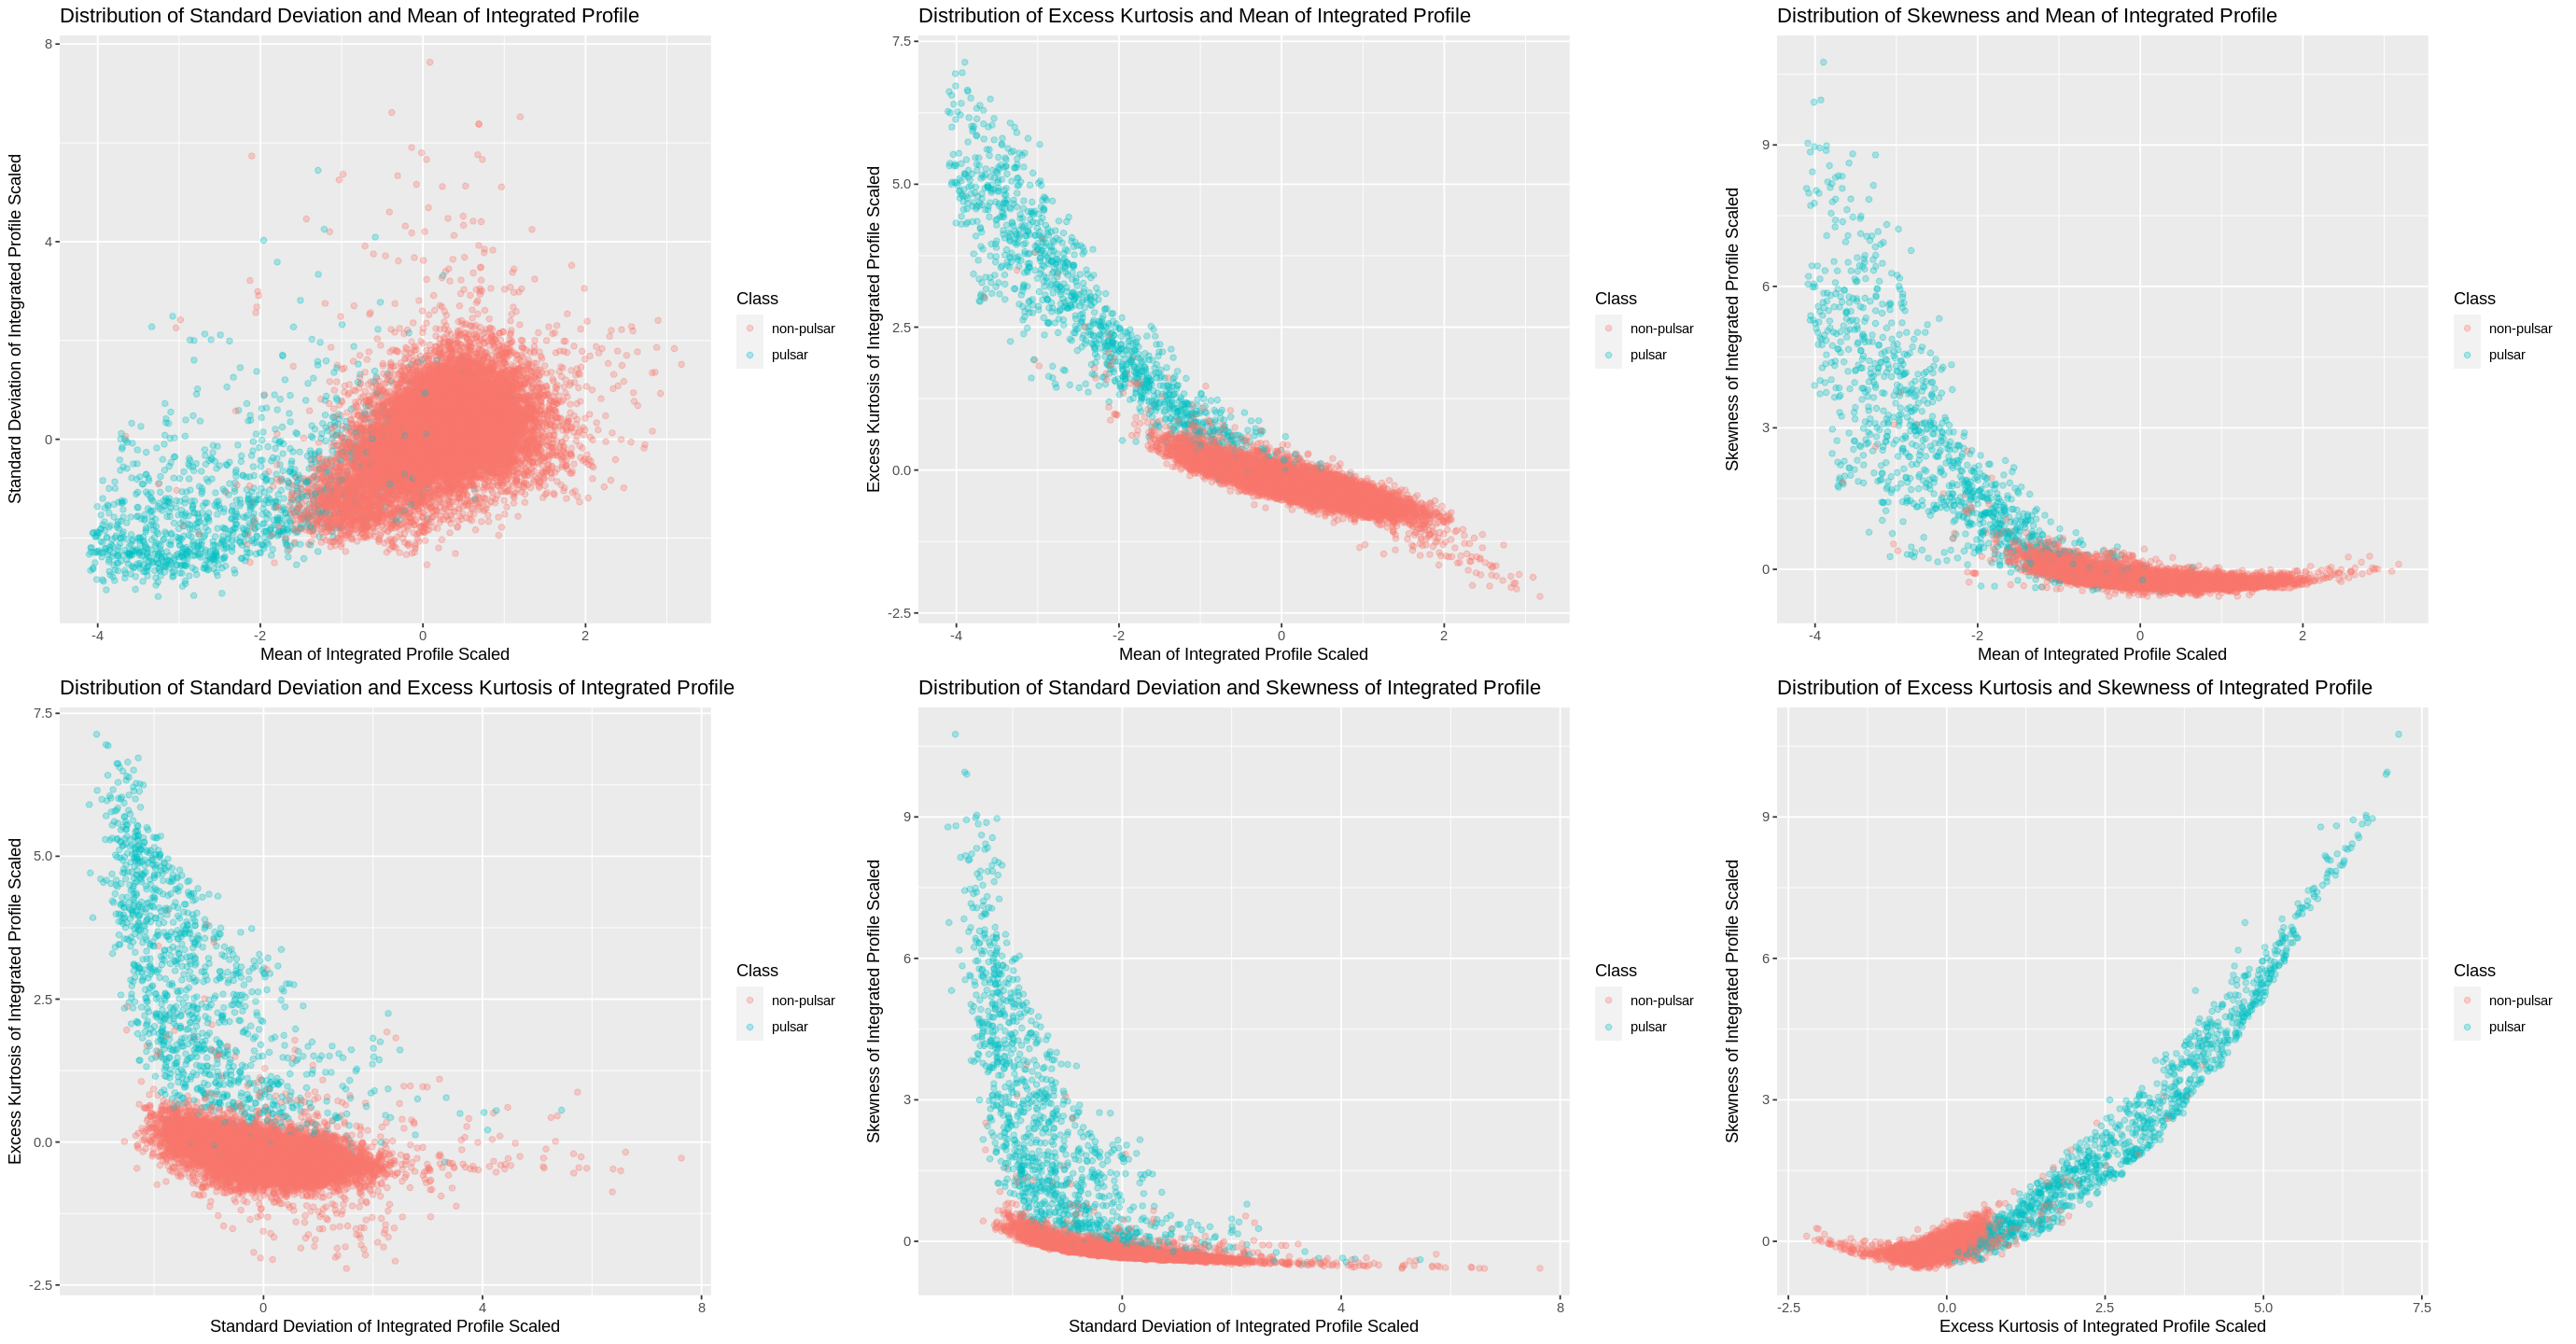

In [156]:
options(repr.plot.width = 23, repr.plot.height = 12)

mean_ip_vs_std_ip <- pulsar_training |>
                        ggplot(aes(x=mean_ip_scaled, y=std_ip_scaled, color=class)) +
                        geom_point(alpha = 0.3) +
                        labs(x="Mean of Integrated Profile Scaled", 
                             y="Standard Deviation of Integrated Profile Scaled", 
                             color="Class", 
                             title="Distribution of Standard Deviation and Mean of Integrated Profile") +
                        theme(text = element_text(size = 11))

mean_ip_vs_ek_ip <- pulsar_training |>
                        ggplot(aes(x=mean_ip_scaled, y=ek_ip_scaled, color=class)) +
                        geom_point(alpha = 0.3) +
                        labs(x="Mean of Integrated Profile Scaled", 
                             y="Excess Kurtosis of Integrated Profile Scaled", 
                             color="Class", 
                             title="Distribution of Excess Kurtosis and Mean of Integrated Profile") +
                        theme(text = element_text(size = 11))

mean_ip_vs_sk_ip <- pulsar_training |>
                        ggplot(aes(x=mean_ip_scaled, y=sk_ip_scaled, color=class)) +
                        geom_point(alpha = 0.3) +
                        labs(x="Mean of Integrated Profile Scaled", 
                             y="Skewness of Integrated Profile Scaled", 
                             color="Class", 
                             title="Distribution of Skewness and Mean of Integrated Profile") +
                        theme(text = element_text(size = 11))

std_ip_vs_ek_ip <- pulsar_training |>
                        ggplot(aes(x=std_ip_scaled, y=ek_ip_scaled, color=class)) +
                        geom_point(alpha = 0.3) +
                        labs(x="Standard Deviation of Integrated Profile Scaled", 
                             y="Excess Kurtosis of Integrated Profile Scaled", 
                             color="Class", 
                             title="Distribution of Standard Deviation and Excess Kurtosis of Integrated Profile") +
                        theme(text = element_text(size = 11))

std_ip_vs_sk_ip <- pulsar_training |>
                        ggplot(aes(x=std_ip_scaled, y=sk_ip_scaled, color=class)) +
                        geom_point(alpha = 0.3) +
                        labs(x="Standard Deviation of Integrated Profile Scaled", 
                             y="Skewness of Integrated Profile Scaled", 
                             color="Class", 
                             title="Distribution of Standard Deviation and Skewness of Integrated Profile") +
                        theme(text = element_text(size = 11))

ek_ip_vs_sk_ip <- pulsar_training |>
                        ggplot(aes(x=ek_ip_scaled, y=sk_ip_scaled, color=class)) +
                        geom_point(alpha = 0.3) +
                        labs(x="Excess Kurtosis of Integrated Profile Scaled", 
                             y="Skewness of Integrated Profile Scaled", 
                             color="Class", 
                             title="Distribution of Excess Kurtosis and Skewness of Integrated Profile") +
                        theme(text = element_text(size = 11))

plot_grid(
     mean_ip_vs_std_ip, mean_ip_vs_ek_ip, mean_ip_vs_sk_ip, std_ip_vs_ek_ip, std_ip_vs_sk_ip, ek_ip_vs_sk_ip,  
     align="hv"
 )

# Methods
We will predict if the given observation is a pulsar or not using the K-Nearest Neighbors classification algorithm. We chose the predictors to be the integrated profile columns because these are the statistics observed during the experiments and they show a clear distinction between pulsars and non-pulsars (R. J. Lyon, 2016). Then, we scaled the data, followed by splitting it into 75% training and 25% testing data. To pick an optimal value of k, we will run a 6-fold cross validation process for more accurate predictions. After training the model, we will test it using the testing data. To visualize the results, we will create a plot of the confusion matrix between the actual values versus the predicted values to better visualize the accuracy of our model.

Cited from:
• Lyon, R. J. (2016). *Why are pulsars hard to find?*. The University of Manchester (United Kingdom).

# Expected Outcomes and Significance

After cleaning our data, the 8 quantitative variables seem to be very ambigious without distinct information on their intrinsic relationship to each observation. Thus, it is expected that we will learn about the relationships of each variable in accordance to the pulsar classification of the observation. This result can lead to further research questions regarding classifications of other neutron stars such as magnetars or even lower class stars. The study of pulsars and more specifically, designing a classification for pulsar stars provide foundational knowledge for future analysis of the most significant attributes of these stars and effective classification model. 
